# Chapter 4.2

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics
import time

In [3]:
import tensorflow.keras as keras
from keras.backend import clear_session
import gc

# Reset Keras Session
def reset_keras():
    clear_session()
    print(gc.collect())
    print(gc.collect())

Using TensorFlow backend.


## Self-created functions

In [4]:
def estimate_node_importance(model, tester_model, layer_sizes, tol_low, tol_high, x, y):
    
    l, a = model.evaluate(x, y, verbose=0, batch_size=256)
    or_weights = model.get_weights()
    weight_len = len(or_weights) - 3
    num_zeros, num_worse, num_important = (0, 0, 0)
    z = []
    wr = []
    imp = []
    amounts = []
    places = []
    avg_imp = np.zeros(len(layer_sizes))
    avg_zero = np.zeros(len(layer_sizes))
    avg_wr = np.zeros(len(layer_sizes))
    for layer, size in enumerate(layer_sizes):
        num_zeros, num_worse, num_important = (0, 0, 0)
        z = []
        wr = []
        imp = []
        for i in range(size):
            w = copy.deepcopy(or_weights)
            w[weight_len - (2*layer+1)][...,i] = 0
            w[weight_len - 2*layer][i] = 0
            tester_model.set_weights(w)
            nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
            change = l - nl
            if change <= tol_high and change >= tol_low:
                num_zeros += 1
                z += [i]
                avg_zero[layer] += change
            elif change > 0:
                num_worse += 1
                wr += [i]
                avg_wr[layer] += change
            else:
                num_important += 1
                imp += [i]
                avg_imp[layer] += change
        amounts.append((num_zeros, num_worse, num_important))
        places.append((z, wr, imp))
        
        if num_important > 0:
            avg_imp[layer] /= num_important
        if num_zeros > 0:
            avg_zero[layer] /= num_zeros
        if num_worse > 0:
            avg_wr[layer] /= num_worse
    
    return amounts, places, avg_imp, avg_zero, avg_wr

## Single-layer ANN

### MNIST

In [5]:
np.random.seed(2020)

In [6]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [8]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
dropout_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
node_importance = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
accs = np.zeros((trials, len(dropout_rate)))
losses = np.zeros((trials, len(dropout_rate)))
avg_node_imp = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
for b, rate in enumerate(dropout_rate):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(rate),
                tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [06:48<00:00, 16.34s/it]


In [10]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI.to_csv('../../../results/node_imp_ANN_dropout_mnist.csv')
NI.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean    2.600000   24.160000      101.240000   3.000000   24.280000   
std     1.080123    6.175759        6.266844   1.554563    6.235116   
min     0.000000   13.000000       93.000000   1.000000   13.000000   
25%     2.000000   19.000000       96.000000   2.000000   20.000000   
50%     3.000000   26.000000       99.000000   3.000000   25.000000   
75%     3.000000   30.000000      107.000000   4.000000   29.000000   
max     4.000000   32.000000      111.000000   6.000000   35.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000   25.00000       25.00       25.000000  25.000000   
mean       100.720000    3.56000       25.08       99.360000   4.280000   
std          6.321392    1.68523        5.40        5.999167   1.671327   
min         90.000000    1.00000       15.00       89.000000   1.000000   
25%         95.000000    2.00000       20.00       95.000000   3.000000   
50%        100.000000    3.00000       26.00       98.000000   4.000000   
75%        106.000000    5.00000       28.00      103.000000   6.000000   
max        112.000000    7.00000       34.00      110.000000   7.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean    31.520000       92.200000   9.120000    6.160000      112.720000  
std      7.632824        7.648529   2.905741    3.923009        4.970915  
min     17.000000       79.000000   4.000000    0.000000      105.000000  
25%     26.000000       87.000000   7.000000    3.000000      108.000000  
50%     31.000000       93.000000  10.000000    6.000000      113.000000  
75%     38.000000       96.000000  11.000000   10.000000      117.000000  
max     45.000000      107.000000  16.000000   13.000000      120.000000

In [11]:
AvgNI = pd.DataFrame(avg_node_imp.reshape(trials, -1), columns=index)
AvgNI.to_csv('../../../results/node_imp_ANN_dropout_mnist.csv')
AvgNI.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -7.659197e-08    0.000592       -0.001268 -6.400893e-07    0.000477   
std    2.730175e-06    0.000236        0.000167  2.355635e-06    0.000142   
min   -8.165836e-06    0.000236       -0.001598 -4.848465e-06    0.000242   
25%   -1.046807e-06    0.000468       -0.001384 -2.257526e-06    0.000359   
50%    0.000000e+00    0.000512       -0.001246 -2.980232e-08    0.000484   
75%    1.337379e-06    0.000680       -0.001116  6.705523e-08    0.000580   
max    4.164875e-06    0.001348       -0.001041  3.382564e-06    0.000767   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.000837 -1.192753e-07    0.000359       -0.000676 -3.577698e-07   
std          0.000100  2.744001e-06    0.000097        0.000072  2.116268e-06   
min         -0.001081 -8.367002e-06    0.000205       -0.000887 -4.614393e-06   
25%         -0.000890 -7.525086e-07    0.000297       -0.000703 -1.929700e-06   
50%         -0.000819  0.000000e+00    0.000345       -0.000667 -1.298530e-07   
75%         -0.000780  7.475416e-07    0.000370       -0.000628  4.002026e-07   
max         -0.000681  4.401430e-06    0.000562       -0.000587  3.889203e-06   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000379       -0.000597 -1.139596e-07    0.000236       -0.001248  
std      0.000101        0.000063  4.584290e-07    0.000132        0.000121  
min      0.000225       -0.000753 -1.731515e-06    0.000000       -0.001502  
25%      0.000325       -0.000619 -3.145801e-07    0.000135       -0.001324  
50%      0.000347       -0.000582  0.000000e+00    0.000224       -0.001217  
75%      0.000438       -0.000565  9.169945e-09    0.000303       -0.001148  
max      0.000636       -0.000499  6.366860e-07    0.000477       -0.001085

In [12]:
A = pd.DataFrame(accs, columns=dropout_rate)
A.to_csv('../../../results/avg_acc_ANN_dropout_mnist.csv')
A.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.975996,0.974920,0.970776,0.960548,0.929428
std,0.001332,0.001311,0.001040,0.001330,0.002302
min,0.973300,0.972700,0.968100,0.959000,0.925300
25%,0.975100,0.974000,0.970500,0.959300,0.927500
50%,0.975800,0.974900,0.971000,0.960600,0.929500
75%,0.976900,0.976000,0.971600,0.961200,0.931200
max,0.978400,0.977200,0.972200,0.964300,0.933700


In [13]:
L = pd.DataFrame(losses, columns=dropout_rate)
L.to_csv('../../../results/loss_ANN_dropout_mnist.csv')
L.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.078860,0.082437,0.097704,0.132805,0.270679
std,0.003902,0.003251,0.003467,0.004118,0.007926
min,0.071328,0.075875,0.093055,0.122683,0.254625
25%,0.076248,0.080093,0.095560,0.131065,0.265815
50%,0.078895,0.081846,0.097387,0.133865,0.269735
75%,0.081526,0.085485,0.098536,0.134896,0.277509
max,0.086907,0.088031,0.107642,0.141336,0.284128


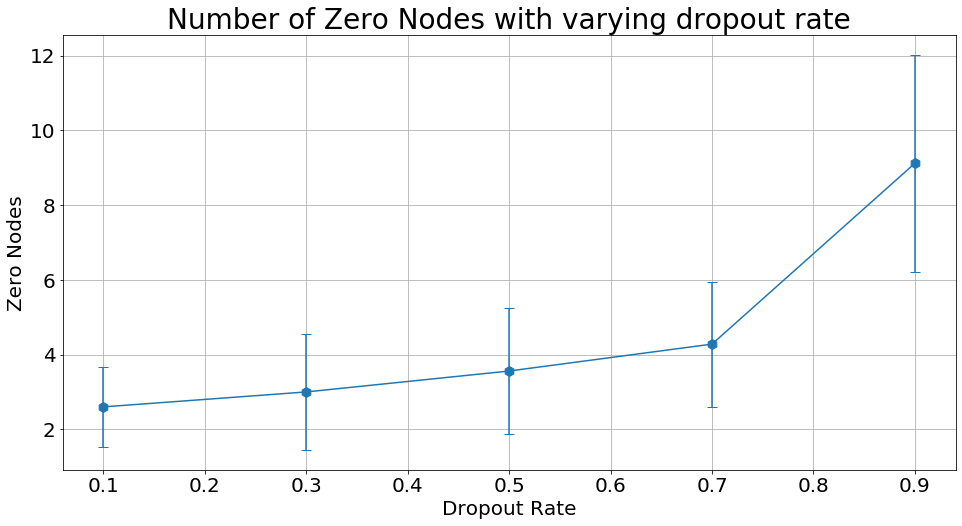

In [14]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Zero Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_ANN_dropout_mnist.png")

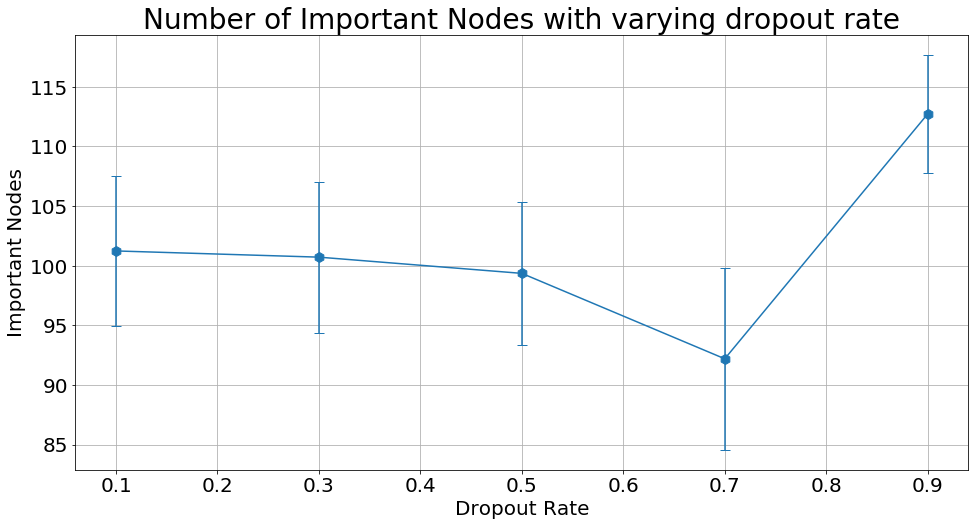

In [15]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Important Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_ANN_dropout_mnist.png")

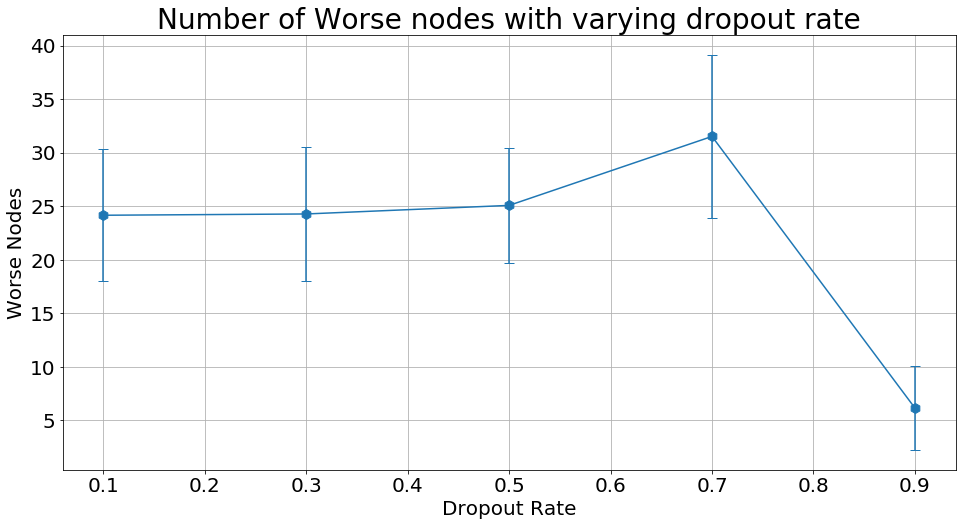

In [16]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_ANN_dropout_mnist.png")

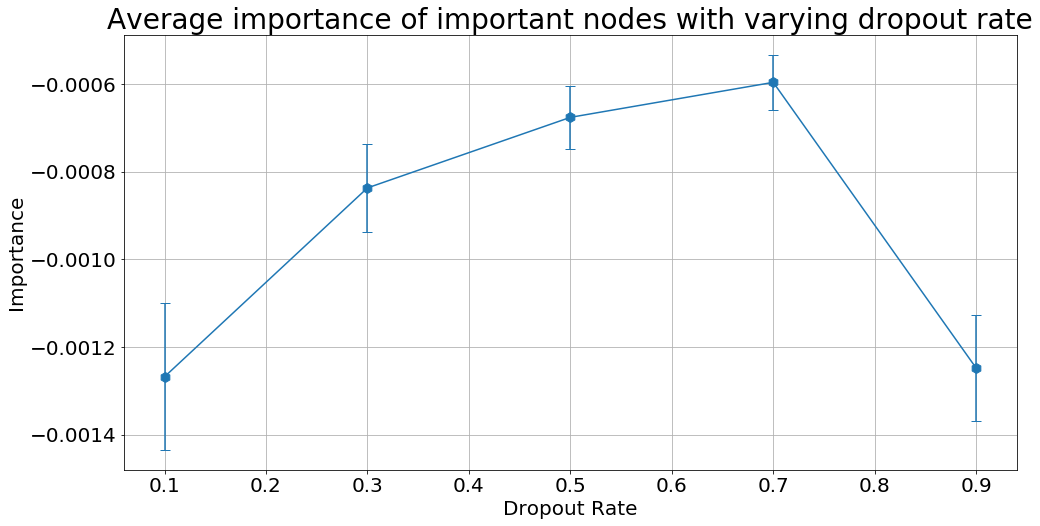

In [17]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average importance of important nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_ANN_dropout_mnist.png")

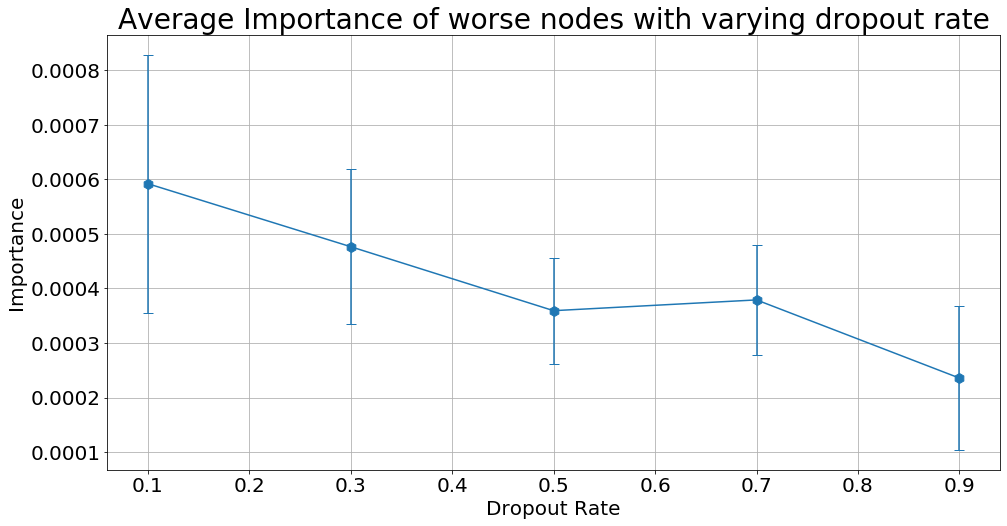

In [18]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average Importance of worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_ANN_dropout_mnist.png")

### Fashion MNIST

In [25]:
np.random.seed(2020)

In [26]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [28]:
tester_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [128]
dropout_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
node_importance = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
accs = np.zeros((trials, len(dropout_rate)))
losses = np.zeros((trials, len(dropout_rate)))
avg_node_imp = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
for b, rate in enumerate(dropout_rate):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(rate),
                tf.keras.layers.Dense(10, activation='softmax')
            ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [06:46<00:00, 16.25s/it]


In [30]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI.to_csv('../../../results/node_imp_ANN_dropout_fmnist.csv')
NI.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000    25.00000       25.000000  25.000000   25.000000   
mean   15.560000    27.76000       84.680000  17.160000   24.680000   
std     3.629509     7.66094        7.197916   3.077878    7.846018   
min     8.000000    10.00000       71.000000  10.000000   11.000000   
25%    13.000000    22.00000       78.000000  15.000000   18.000000   
50%    16.000000    27.00000       85.000000  17.000000   24.000000   
75%    18.000000    32.00000       88.000000  19.000000   31.000000   
max    21.000000    42.00000      101.000000  26.000000   41.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        86.160000  18.280000   25.960000       83.760000  23.560000   
std          7.162867   3.802631    7.694587        8.297992   5.346962   
min         70.000000  10.000000   11.000000       70.000000  16.000000   
25%         82.000000  16.000000   20.000000       77.000000  19.000000   
50%         86.000000  18.000000   25.000000       85.000000  25.000000   
75%         90.000000  22.000000   32.000000       89.000000  27.000000   
max        102.000000  25.000000   43.000000       96.000000  34.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000        25.00000  25.000000   25.000000       25.000000  
mean    20.320000        84.12000  38.040000    5.840000       84.120000  
std      7.075309         8.22253   4.945368    4.597826        5.085273  
min     11.000000        70.00000  28.000000    0.000000       73.000000  
25%     13.000000        79.00000  36.000000    3.000000       81.000000  
50%     20.000000        83.00000  38.000000    5.000000       85.000000  
75%     23.000000        90.00000  40.000000    7.000000       89.000000  
max     35.000000       100.00000  53.000000   18.000000       91.000000

In [31]:
AvgNI = pd.DataFrame(avg_node_imp.reshape(trials, -1), columns=index)
AvgNI.to_csv('../../../results/node_imp_ANN_dropout_fmnist.csv')
AvgNI.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean   4.933878e-08    0.001116       -0.001860 -1.143259e-07    0.000839   
std    3.244171e-07    0.000444        0.000281  4.521153e-07    0.000434   
min   -5.520525e-07    0.000267       -0.002636 -1.386685e-06    0.000263   
25%   -1.899898e-07    0.000841       -0.001985 -4.203696e-07    0.000562   
50%    0.000000e+00    0.001092       -0.001820 -2.980232e-09    0.000773   
75%    2.384186e-07    0.001409       -0.001718  1.724277e-07    0.000961   
max    7.301569e-07    0.002091       -0.001398  8.064158e-07    0.001945   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.001297  1.244185e-08    0.000649       -0.001043  2.919519e-08   
std          0.000226  4.457246e-07    0.000308        0.000153  4.399585e-07   
min         -0.001735 -1.193583e-06    0.000183       -0.001382 -7.909078e-07   
25%         -0.001393 -1.177192e-07    0.000425       -0.001130 -2.647822e-07   
50%         -0.001275  0.000000e+00    0.000612       -0.001022  1.887480e-08   
75%         -0.001145  3.265298e-07    0.000762       -0.000924  2.594555e-07   
max         -0.000893  9.208918e-07    0.001324       -0.000797  1.000240e-06   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000434       -0.001043 -2.059937e-08    0.000263       -0.002247  
std      0.000235        0.000138  9.912877e-08    0.000194        0.000224  
min      0.000208       -0.001247 -2.227331e-07    0.000000       -0.002755  
25%      0.000288       -0.001141 -7.224805e-08    0.000135       -0.002365  
50%      0.000383       -0.001071  0.000000e+00    0.000220       -0.002253  
75%      0.000507       -0.000980  3.921358e-08    0.000320       -0.002093  
max      0.001192       -0.000719  1.711723e-07    0.000684       -0.001785

In [32]:
A = pd.DataFrame(accs, columns=dropout_rate)
A.to_csv('../../../results/avg_acc_ANN_dropout_fmnist.csv')
A.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.870732,0.867160,0.860968,0.848816,0.785596
std,0.004329,0.003218,0.003341,0.003734,0.010724
min,0.857900,0.857400,0.854300,0.838400,0.769300
25%,0.868700,0.865500,0.859200,0.847800,0.775900
50%,0.871300,0.867200,0.861100,0.849500,0.787500
75%,0.873600,0.868400,0.862800,0.851400,0.792700
max,0.877400,0.872000,0.867600,0.853500,0.809300


In [33]:
L = pd.DataFrame(losses, columns=dropout_rate)
L.to_csv('../../../results/loss_ANN_dropout_fmnist.csv')
L.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.359838,0.369610,0.388063,0.421322,0.613274
std,0.010395,0.008076,0.006376,0.006814,0.015072
min,0.344187,0.356352,0.377779,0.411271,0.589429
25%,0.354341,0.363902,0.383788,0.417028,0.603148
50%,0.359127,0.367890,0.386710,0.420158,0.609849
75%,0.361649,0.375991,0.393166,0.424225,0.622043
max,0.390180,0.388487,0.400771,0.437632,0.643980


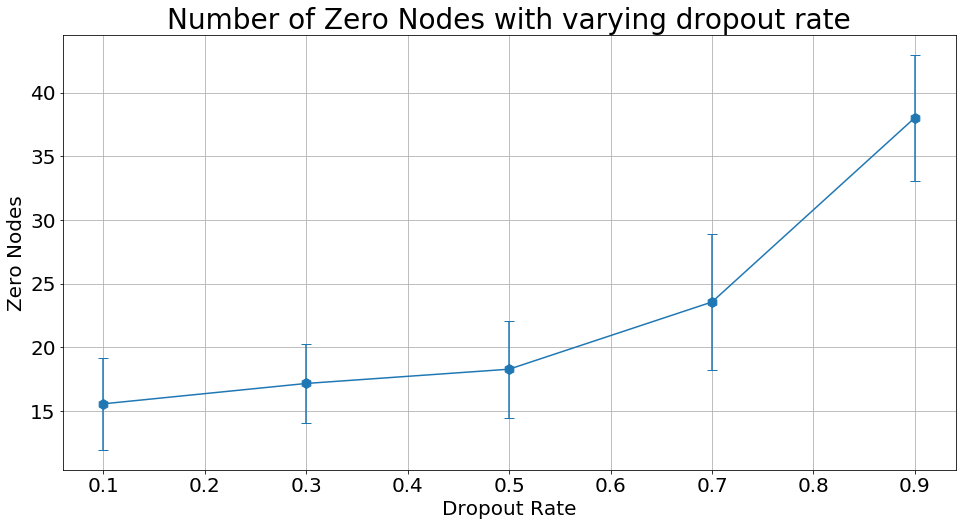

In [34]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Zero Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_ANN_dropout_fmnist.png")

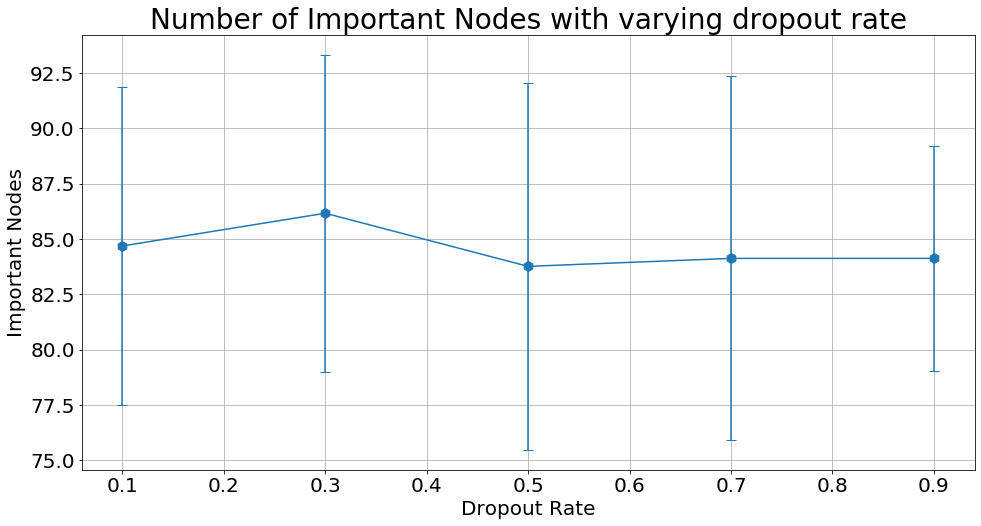

In [35]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Important Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_ANN_dropout_fmnist.png")

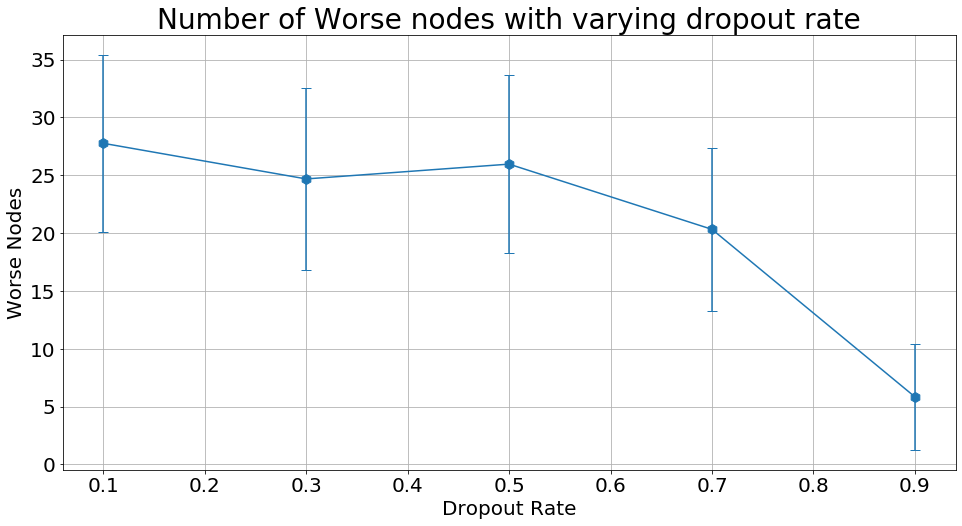

In [36]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = NI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= NI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Number of Worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_ANN_dropout_fmnist.png")

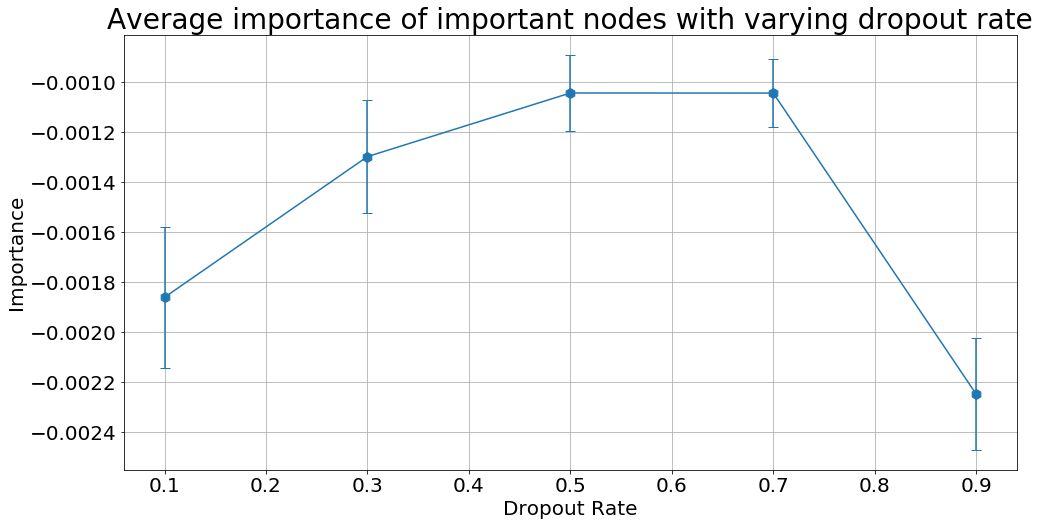

In [37]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average importance of important nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_ANN_dropout_fmnist.png")

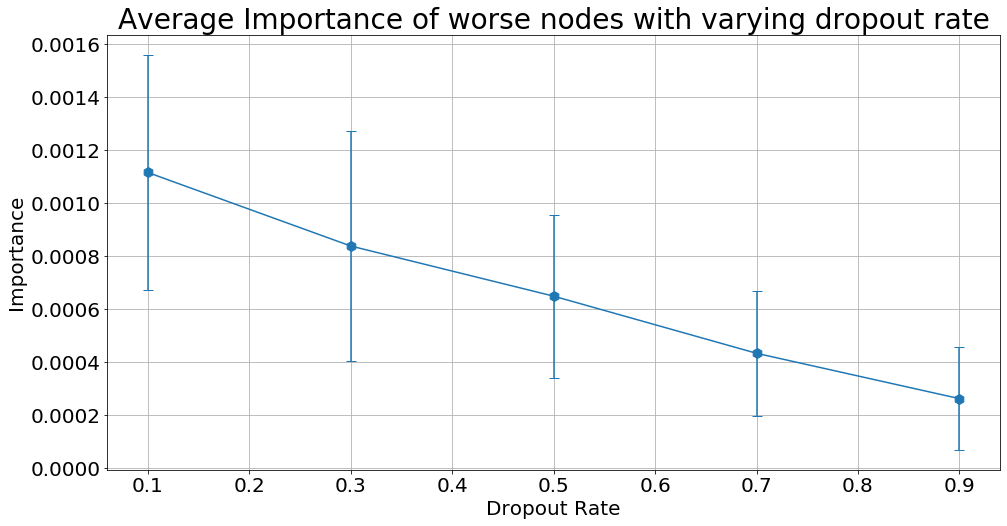

In [38]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
mz = AvgNI.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
stdz= AvgNI.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=mz, yerr=stdz, capsize=5, marker='h', markersize=10, alpha=1)
plt.title("Average Importance of worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_ANN_dropout_fmnist.png")

## Multi-layer Perceptron

### MNIST

In [39]:
np.random.seed(2020)

In [40]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [41]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [42]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
dropout_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
node_importance = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
accs = np.zeros((trials, len(dropout_rate)))
losses = np.zeros((trials, len(dropout_rate)))
avg_node_imp = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
for b, rate in enumerate(dropout_rate):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [10:07<00:00, 24.28s/it]


In [44]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_1 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/node_imp_MLP_dropout_mnist.csv')
NI_1.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean    0.360000   10.600000       21.040000   0.200000   14.640000   
std     0.568624    2.661453        2.621704   0.408248    3.327662   
min     0.000000    6.000000       16.000000   0.000000    6.000000   
25%     0.000000    8.000000       19.000000   0.000000   13.000000   
50%     0.000000   11.000000       21.000000   0.000000   15.000000   
75%     1.000000   13.000000       23.000000   0.000000   17.000000   
max     2.000000   16.000000       25.000000   1.000000   23.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count         25.0000  25.000000   25.000000       25.000000  25.000000   
mean          17.1600   0.360000   12.600000       19.040000   0.160000   
std            3.2104   0.568624    4.272002        4.410971   0.374166   
min            9.0000   0.000000    4.000000       11.000000   0.000000   
25%           15.0000   0.000000    9.000000       16.000000   0.000000   
50%           17.0000   0.000000   13.000000       18.000000   0.000000   
75%           19.0000   1.000000   16.000000       23.000000   0.000000   
max           26.0000   2.000000   21.000000       28.000000   1.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean     5.000000       26.840000  25.960000    0.160000        5.880000  
std      4.983305        5.071818  11.476352    0.472582       11.129241  
min      0.000000       13.000000   0.000000    0.000000        0.000000  
25%      1.000000       24.000000  32.000000    0.000000        0.000000  
50%      4.000000       28.000000  32.000000    0.000000        0.000000  
75%      8.000000       30.000000  32.000000    0.000000        0.000000  
max     19.000000       32.000000  32.000000    2.000000       30.000000

In [45]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/node_imp_MLP_dropout_mnist.csv')
AvgNI_1.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -2.269447e-07    0.001262       -0.001752  3.200769e-07    0.000945   
std    1.041874e-06    0.000491        0.000439  3.211895e-06    0.000412   
min   -5.207956e-06    0.000362       -0.002899 -9.790063e-06    0.000501   
25%    0.000000e+00    0.000964       -0.001975  0.000000e+00    0.000665   
50%    0.000000e+00    0.001284       -0.001669  0.000000e+00    0.000892   
75%    0.000000e+00    0.001494       -0.001515  0.000000e+00    0.001147   
max    0.000000e+00    0.002399       -0.001023  8.732080e-06    0.002401   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.000904 -5.209446e-07    0.000873       -0.001152 -2.694130e-07   
std          0.000254  3.329997e-06    0.000290        0.000311  1.965607e-06   
min         -0.001455 -9.581447e-06    0.000380       -0.001843 -5.185604e-06   
25%         -0.001085  0.000000e+00    0.000638       -0.001315  0.000000e+00   
50%         -0.000862  0.000000e+00    0.000907       -0.001116  0.000000e+00   
75%         -0.000698  0.000000e+00    0.001032       -0.000959  0.000000e+00   
max         -0.000527  4.753470e-06    0.001697       -0.000695  6.139278e-06   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000691       -0.003642 -3.147324e-07    0.000009       -0.000332  
std      0.000492        0.000994  1.238649e-06    0.000029        0.000934  
min      0.000000       -0.005834 -6.198883e-06    0.000000       -0.004451  
25%      0.000336       -0.004471 -3.725290e-08    0.000000        0.000000  
50%      0.000617       -0.003580  0.000000e+00    0.000000        0.000000  
75%      0.001030       -0.003033  0.000000e+00    0.000000        0.000000  
max      0.001900       -0.001518  5.215406e-08    0.000110        0.000000

In [46]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_2 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/node_imp_MLP_dropout_mnist.csv')
NI_2.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000   25.00000   25.000000   
mean    1.000000   23.160000       39.840000    0.84000   31.040000   
std     0.912871    4.190068        3.933616    0.85049    3.878144   
min     0.000000   17.000000       33.000000    0.00000   23.000000   
25%     0.000000   21.000000       38.000000    0.00000   29.000000   
50%     1.000000   22.000000       41.000000    1.00000   32.000000   
75%     2.000000   25.000000       43.000000    1.00000   34.000000   
max     3.000000   31.000000       45.000000    3.00000   37.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000  25.000000   
mean        32.120000   0.680000   35.080000       28.240000   0.440000   
std          3.789459   0.748331    6.109555        6.246866   0.650641   
min         27.000000   0.000000   21.000000       19.000000   0.000000   
25%         29.000000   0.000000   31.000000       23.000000   0.000000   
50%         31.000000   1.000000   37.000000       26.000000   0.000000   
75%         34.000000   1.000000   40.000000       32.000000   1.000000   
max         40.000000   2.000000   43.000000       42.000000   2.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000        25.00000  25.000000   25.000000        25.00000  
mean    19.320000        44.24000  52.960000    0.920000        10.12000  
std      9.361802         9.57549  20.713281    1.891208        19.30095  
min      3.000000        26.00000   7.000000    0.000000         0.00000  
25%     13.000000        38.00000  64.000000    0.000000         0.00000  
50%     17.000000        47.00000  64.000000    0.000000         0.00000  
75%     26.000000        51.00000  64.000000    0.000000         0.00000  
max     37.000000        61.00000  64.000000    6.000000        56.00000

In [47]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/node_imp_MLP_dropout_mnist.csv')
AvgNI_2.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -1.849234e-07    0.000945       -0.001221 -3.451606e-07    0.000672   
std    2.466565e-06    0.000348        0.000253  4.417352e-06    0.000253   
min   -5.342066e-06    0.000373       -0.001735 -8.568168e-06    0.000361   
25%   -5.587935e-07    0.000760       -0.001300 -3.769994e-06    0.000496   
50%    0.000000e+00    0.000861       -0.001199  0.000000e+00    0.000630   
75%    0.000000e+00    0.001182       -0.001090  1.445413e-06    0.000790   
max    7.629395e-06    0.001895       -0.000692  9.655952e-06    0.001529   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.000653  3.391504e-07    0.000605       -0.000594 -1.657009e-07   
std          0.000137  3.020217e-06    0.000189        0.000112  4.092461e-06   
min         -0.000919 -7.838011e-06    0.000351       -0.000846 -9.894371e-06   
25%         -0.000719  0.000000e+00    0.000498       -0.000651  0.000000e+00   
50%         -0.000630  0.000000e+00    0.000584       -0.000558  0.000000e+00   
75%         -0.000548  1.035631e-06    0.000648       -0.000524  0.000000e+00   
max         -0.000463  8.985400e-06    0.001240       -0.000406  9.834766e-06   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000657       -0.001827  3.541250e-08    0.000035       -0.000201  
std      0.000291        0.000634  3.625477e-07    0.000099        0.000558  
min      0.000116       -0.003431 -6.285581e-07    0.000000       -0.002642  
25%      0.000455       -0.002228 -3.725290e-09    0.000000        0.000000  
50%      0.000624       -0.001747  0.000000e+00    0.000000        0.000000  
75%      0.000880       -0.001366  7.450581e-09    0.000000        0.000000  
max      0.001150       -0.001022  1.128515e-06    0.000445        0.000000

In [48]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_3 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/node_imp_MLP_dropout_mnist.csv')
NI_3.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000        25.00000  25.000000   25.000000   
mean    3.800000   30.280000        93.92000   5.360000   36.560000   
std     2.041241    6.877015         6.78798   2.325224    6.752037   
min     0.000000   17.000000        70.00000   1.000000   22.000000   
25%     2.000000   27.000000        91.00000   4.000000   31.000000   
50%     4.000000   31.000000        95.00000   5.000000   39.000000   
75%     5.000000   32.000000        96.00000   7.000000   42.000000   
max     8.000000   53.000000       104.00000  10.000000   49.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000        25.00000  25.000000   
mean        86.080000  15.880000   38.920000        73.20000  58.240000   
std          7.023295   4.548993    5.692978         6.86173   4.968903   
min         74.000000   8.000000   28.000000        55.00000  49.000000   
25%         82.000000  13.000000   36.000000        69.00000  56.000000   
50%         86.000000  15.000000   38.000000        75.00000  58.000000   
75%         91.000000  18.000000   42.000000        78.00000  62.000000   
max        105.000000  27.000000   50.000000        83.00000  66.000000   

                                          0.9                              
      Worse Nodes Important Nodes  Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000   25.000000   25.000000       25.000000  
mean    23.080000       46.680000  125.120000    0.120000        2.760000  
std      8.159453        9.494384    5.911289    0.439697        5.658916  
min      6.000000       28.000000  109.000000    0.000000        0.000000  
25%     17.000000       40.000000  128.000000    0.000000        0.000000  
50%     25.000000       46.000000  128.000000    0.000000        0.000000  
75%     27.000000       54.000000  128.000000    0.000000        0.000000  
max     37.000000       64.000000  128.000000    2.000000       17.000000

In [49]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/node_imp_MLP_dropout_mnist.csv')
AvgNI_3.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean   6.636970e-07    0.000705       -0.001350 -5.309525e-07    0.000628   
std    1.193810e-06    0.000250        0.000244  1.313620e-06    0.000228   
min   -1.447896e-06    0.000308       -0.002095 -3.329345e-06    0.000372   
25%    0.000000e+00    0.000494       -0.001449 -1.458185e-06    0.000489   
50%    0.000000e+00    0.000717       -0.001301 -2.563000e-07    0.000581   
75%    1.261632e-06    0.000805       -0.001222  1.370907e-07    0.000726   
max    3.635883e-06    0.001330       -0.001036  1.860783e-06    0.001481   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.000979  4.799665e-08    0.000732       -0.001085 -2.730684e-08   
std          0.000154  5.068715e-07    0.000213        0.000153  1.520617e-07   
min         -0.001435 -1.416852e-06    0.000430       -0.001334 -3.623584e-07   
25%         -0.001048 -7.982765e-08    0.000626       -0.001181 -1.289407e-07   
50%         -0.000987  0.000000e+00    0.000726       -0.001055  1.359404e-08   
75%         -0.000887  2.789829e-07    0.000802       -0.000965  8.940697e-08   
max         -0.000711  1.178433e-06    0.001554       -0.000804  1.807061e-07   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000786       -0.002740 -3.573903e-09    0.000153       -0.001170  
std      0.000318        0.000916  2.434407e-08    0.000745        0.003382  
min      0.000189       -0.005454 -7.947286e-08    0.000000       -0.015872  
25%      0.000600       -0.002999 -9.313226e-09    0.000000        0.000000  
50%      0.000726       -0.002612  0.000000e+00    0.000000        0.000000  
75%      0.000880       -0.002121  0.000000e+00    0.000000        0.000000  
max      0.001661       -0.001450  7.549922e-08    0.003728        0.000000

In [50]:
A = pd.DataFrame(accs, columns=dropout_rate)
A.to_csv('../../../results/avg_acc_MLP_dropout_mnist.csv')
A.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.973924,0.969796,0.955612,0.742760,0.132516
std,0.001857,0.001572,0.001534,0.059783,0.038825
min,0.969600,0.966300,0.953100,0.644700,0.113500
25%,0.972600,0.968900,0.954700,0.690900,0.113500
50%,0.974000,0.970000,0.955700,0.741200,0.113500
75%,0.974800,0.970800,0.956900,0.792000,0.113500
max,0.977500,0.972800,0.957900,0.838400,0.210600


In [51]:
L = pd.DataFrame(losses, columns=dropout_rate)
L.to_csv('../../../results/loss_MLP_dropout_mnist.csv')
L.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.089943,0.109234,0.173390,0.760509,2.250420
std,0.008020,0.005524,0.008613,0.102940,0.103486
min,0.076795,0.099607,0.159852,0.589153,2.020127
25%,0.085879,0.105329,0.168142,0.700569,2.300993
50%,0.089269,0.108351,0.171324,0.751601,2.301106
75%,0.093714,0.112640,0.175501,0.835142,2.301118
max,0.106738,0.123753,0.196007,0.915414,2.301268


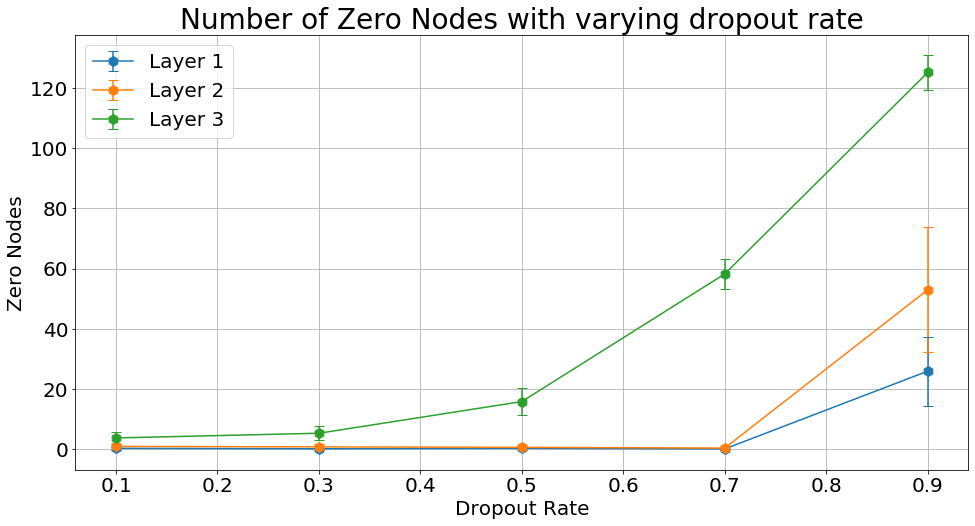

In [52]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_MLP_dropout_mnist.png")

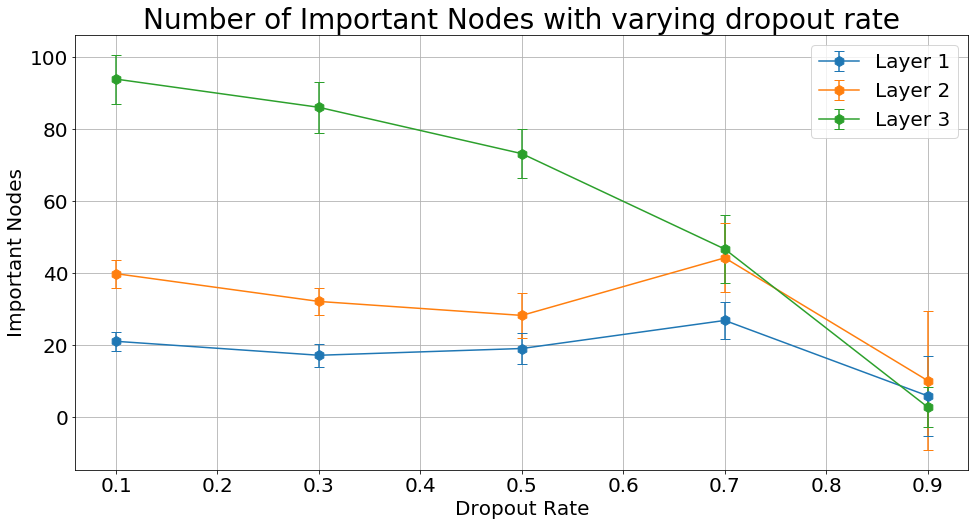

In [53]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_MLP_dropout_mnist.png")

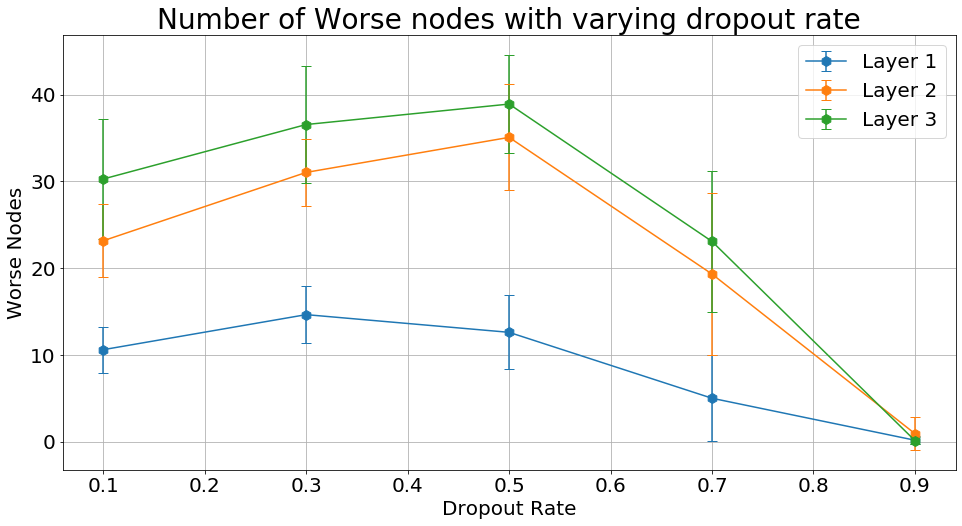

In [54]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_MLP_dropout_mnist.png")

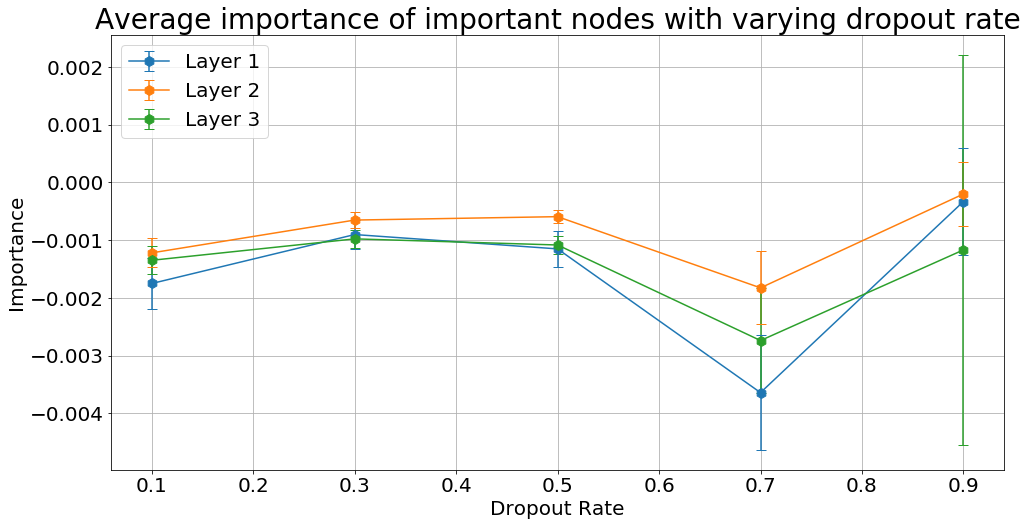

In [55]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_MLP_dropout_mnist.png")

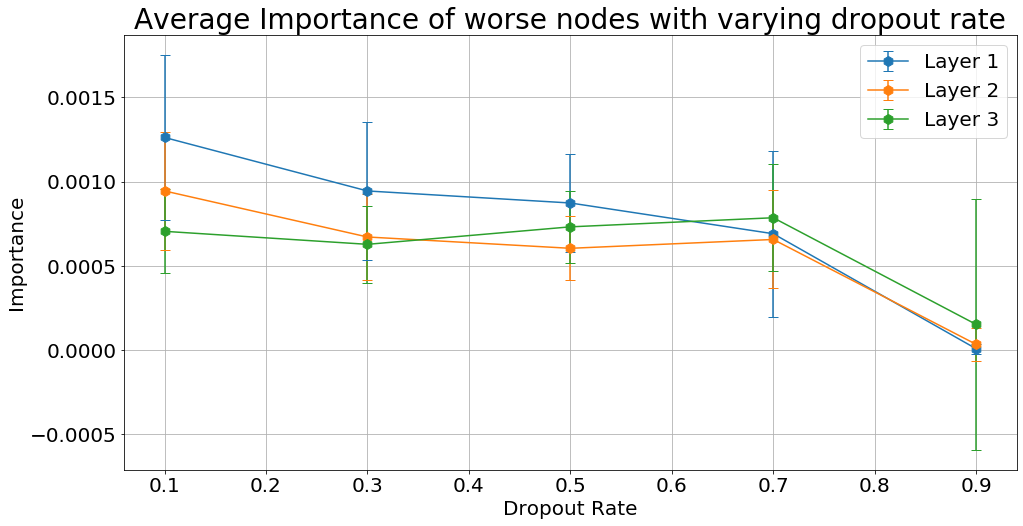

In [56]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_MLP_dropout_mnist.png")

### Fashion MNIST

In [57]:
np.random.seed(2020)

In [58]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [59]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [60]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [61]:
trials = 25
low_tol = -1e-5
high_tol = 1e-5
layer_sizes = [32, 64, 128]
dropout_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
node_importance = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
accs = np.zeros((trials, len(dropout_rate)))
losses = np.zeros((trials, len(dropout_rate)))
avg_node_imp = np.zeros((trials, len(dropout_rate), len(layer_sizes), 3))
for b, rate in enumerate(dropout_rate):
    for trial in tqdm.trange(trials):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(rate),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(x_train, y_train, verbose=0, epochs=5)
        losses[trial, b], accs[trial, b] = model.evaluate(x_test, y_test, verbose=0)
        tmp_a, _, ai, az, aw = estimate_node_importance(model, tester_model, layer_sizes, low_tol, high_tol, x_val, y_val)
        for i, (nz, nw, ni) in enumerate(tmp_a):
            node_importance[trial, b, i, 0] = nz
            node_importance[trial, b, i, 1] = nw
            node_importance[trial, b, i, 2] = ni
            avg_node_imp[trial, b, i] = [az[i], aw[i], ai[i]]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [10:11<00:00, 24.48s/it]


In [62]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_1 = pd.DataFrame(node_importance[:, :, 0, :].reshape(trials, -1), columns=index)
NI_1.to_csv('../../../results/node_imp_MLP_dropout_fmnist.csv')
NI_1.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000        25.00000  25.000000   25.000000   
mean    0.440000    8.240000        23.32000   0.200000    8.480000   
std     0.583095    4.294182         4.23989   0.408248    4.874423   
min     0.000000    2.000000        13.00000   0.000000    1.000000   
25%     0.000000    5.000000        21.00000   0.000000    6.000000   
50%     0.000000    8.000000        23.00000   0.000000    8.000000   
75%     1.000000   11.000000        27.00000   0.000000   11.000000   
max     2.000000   19.000000        30.00000   1.000000   17.000000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count        25.00000      25.00   25.000000       25.000000  25.000000   
mean         23.32000       0.08    4.920000       27.000000   0.400000   
std           4.94739       0.40    2.396525        2.362908   0.912871   
min          14.00000       0.00    0.000000       23.000000   0.000000   
25%          20.00000       0.00    3.000000       25.000000   0.000000   
50%          24.00000       0.00    5.000000       27.000000   0.000000   
75%          26.00000       0.00    7.000000       28.000000   0.000000   
max          31.00000       2.00    9.000000       32.000000   4.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000       25.00       25.000000  
mean     1.440000       30.160000  23.560000        0.12        8.320000  
std      2.678308        2.703085   8.180668        0.60        8.254898  
min      0.000000       22.000000   7.000000        0.00        0.000000  
25%      0.000000       29.000000  16.000000        0.00        0.000000  
50%      0.000000       31.000000  26.000000        0.00        6.000000  
75%      2.000000       32.000000  32.000000        0.00       16.000000  
max     10.000000       32.000000  32.000000        3.00       25.000000

In [63]:
AvgNI_1 = pd.DataFrame(avg_node_imp[:, :, 0, :].reshape(trials, -1), columns=index)
AvgNI_1.to_csv('../../../results/node_imp_MLP_dropout_fmnist.csv')
AvgNI_1.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean   1.192093e-07    0.001886       -0.003602 -8.881092e-07    0.001187   
std    2.112026e-06    0.001063        0.000644  2.856453e-06    0.000555   
min   -6.794930e-06    0.000211       -0.005351 -9.298325e-06    0.000291   
25%    0.000000e+00    0.001095       -0.003866  0.000000e+00    0.000759   
50%    0.000000e+00    0.001710       -0.003579  0.000000e+00    0.001118   
75%    0.000000e+00    0.002315       -0.003210  0.000000e+00    0.001537   
max    5.662441e-06    0.003888       -0.002593  3.159046e-06    0.002133   

                                0.5                                    0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000       25.0   
mean        -0.002755 -1.573563e-07    0.000969       -0.003233        0.0   
std          0.000552  7.867813e-07    0.000715        0.000592        0.0   
min         -0.004209 -3.933907e-06    0.000000       -0.004304        0.0   
25%         -0.003026  0.000000e+00    0.000605       -0.003588        0.0   
50%         -0.002851  0.000000e+00    0.000884       -0.003240        0.0   
75%         -0.002460  0.000000e+00    0.001094       -0.002839        0.0   
max         -0.001561  0.000000e+00    0.002735       -0.001937        0.0   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000133       -0.004448 -3.194160e-07    0.000031       -0.000395  
std      0.000315        0.001973  3.863398e-07    0.000153        0.000546  
min      0.000000       -0.008317 -1.256283e-06    0.000000       -0.001960  
25%      0.000000       -0.005739 -4.609426e-07    0.000000       -0.000555  
50%      0.000000       -0.004241 -1.788139e-07    0.000000       -0.000226  
75%      0.000195       -0.002879 -1.538184e-08    0.000000        0.000000  
max      0.001472       -0.001429  2.649095e-08    0.000764        0.000000

In [64]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_2 = pd.DataFrame(node_importance[:, :, 1, :].reshape(trials, -1), columns=index)
NI_2.to_csv('../../../results/node_imp_MLP_dropout_fmnist.csv')
NI_2.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count      25.00   25.000000       25.000000   25.00000     25.0000   
mean        0.64   20.880000       42.480000    0.64000     22.6800   
std         0.70    6.802696        6.904829    0.81035      6.8661   
min         0.00    7.000000       28.000000    0.00000     13.0000   
25%         0.00   15.000000       38.000000    0.00000     18.0000   
50%         1.00   21.000000       42.000000    0.00000     21.0000   
75%         1.00   25.000000       48.000000    1.00000     28.0000   
max         2.00   35.000000       57.000000    3.00000     40.0000   

                             0.5                                    0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes Zero Nodes   
count       25.000000  25.000000   25.000000        25.00000  25.000000   
mean        40.680000   0.440000   16.880000        46.68000   1.360000   
std          6.681567   0.650641    5.403086         5.46748   1.604161   
min         24.000000   0.000000    4.000000        37.00000   0.000000   
25%         36.000000   0.000000   14.000000        44.00000   0.000000   
50%         43.000000   0.000000   17.000000        47.00000   1.000000   
75%         46.000000   1.000000   19.000000        50.00000   2.000000   
max         51.000000   2.000000   26.000000        60.00000   8.000000   

                                         0.9                              
      Worse Nodes Important Nodes Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  25.000000   25.000000       25.000000  
mean     3.880000       58.760000  42.040000    5.400000       16.560000  
std      6.514855        6.881618  20.608413    5.392897       16.620971  
min      0.000000       36.000000   7.000000    0.000000        0.000000  
25%      0.000000       58.000000  23.000000    0.000000        0.000000  
50%      1.000000       62.000000  47.000000    5.000000       11.000000  
75%      4.000000       63.000000  64.000000    9.000000       30.000000  
max     26.000000       64.000000  64.000000   16.000000       52.000000

In [65]:
AvgNI_2 = pd.DataFrame(avg_node_imp[:, :, 1, :].reshape(trials, -1), columns=index)
AvgNI_2.to_csv('../../../results/node_imp_MLP_dropout_fmnist.csv')
AvgNI_2.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean   4.971027e-07    0.001370       -0.001842 -4.394849e-07    0.000905   
std    3.957383e-06    0.000605        0.000396  4.021052e-06    0.000382   
min   -8.493662e-06    0.000399       -0.002703 -7.763505e-06    0.000409   
25%    0.000000e+00    0.001021       -0.002058 -1.758337e-06    0.000644   
50%    0.000000e+00    0.001423       -0.001763  0.000000e+00    0.000774   
75%    0.000000e+00    0.001617       -0.001638  0.000000e+00    0.001098   
max    9.030104e-06    0.002979       -0.001238  9.417534e-06    0.001903   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.001210  2.384186e-08    0.000758       -0.001305  6.765127e-07   
std          0.000211  3.664747e-06    0.000405        0.000215  2.431166e-06   
min         -0.001699 -8.195639e-06    0.000217       -0.001695 -3.576279e-06   
25%         -0.001396  0.000000e+00    0.000582       -0.001455  0.000000e+00   
50%         -0.001219  0.000000e+00    0.000630       -0.001356  0.000000e+00   
75%         -0.001042  0.000000e+00    0.000744       -0.001166  9.536743e-07   
max         -0.000812  9.208918e-06    0.001823       -0.000853  6.198883e-06   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000218       -0.001953 -1.441479e-07    0.000072       -0.000218  
std      0.000417        0.000875  6.867510e-07    0.000099        0.000294  
min      0.000000       -0.003596 -1.725029e-06    0.000000       -0.001033  
25%      0.000000       -0.002592 -3.595201e-07    0.000000       -0.000280  
50%      0.000031       -0.001938 -9.366444e-08    0.000037       -0.000145  
75%      0.000184       -0.001196  1.490116e-08    0.000086        0.000000  
max      0.001700       -0.000634  1.702990e-06    0.000399        0.000000

In [66]:
index = pd.MultiIndex.from_product([dropout_rate, ['Zero Nodes', 'Worse Nodes', 'Important Nodes']])
NI_3 = pd.DataFrame(node_importance[:, :, 2, :].reshape(trials, -1), columns=index)
NI_3.to_csv('../../../results/node_imp_MLP_dropout_fmnist.csv')
NI_3.describe()

0.1                                    0.3              \
      Zero Nodes Worse Nodes Important Nodes Zero Nodes Worse Nodes   
count  25.000000   25.000000       25.000000  25.000000   25.000000   
mean   20.720000   28.080000       79.200000  29.320000   26.840000   
std     2.574231    7.878875        7.494442   3.197916    4.749386   
min    17.000000    8.000000       65.000000  25.000000   19.000000   
25%    19.000000   24.000000       76.000000  27.000000   23.000000   
50%    21.000000   29.000000       80.000000  29.000000   27.000000   
75%    22.000000   31.000000       82.000000  32.000000   29.000000   
max    27.000000   46.000000       99.000000  35.000000   40.000000   

                             0.5                                     0.7  \
      Important Nodes Zero Nodes Worse Nodes Important Nodes  Zero Nodes   
count       25.000000  25.000000   25.000000       25.000000   25.000000   
mean        71.840000  49.560000   20.440000       58.000000   88.120000   
std          5.296854   4.282523    5.180734        5.923119   11.057878   
min         62.000000  40.000000    9.000000       49.000000   68.000000   
25%         68.000000  47.000000   18.000000       55.000000   82.000000   
50%         72.000000  50.000000   22.000000       58.000000   85.000000   
75%         77.000000  52.000000   23.000000       60.000000   93.000000   
max         81.000000  57.000000   29.000000       76.000000  110.000000   

                                          0.9                              
      Worse Nodes Important Nodes  Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000   25.000000   25.000000       25.000000  
mean     3.880000       36.000000  122.840000    0.600000        4.560000  
std      3.822303       10.400321    5.920867    1.258306        5.083306  
min      0.000000       14.000000  105.000000    0.000000        0.000000  
25%      1.000000       34.000000  119.000000    0.000000        0.000000  
50%      3.000000       38.000000  125.000000    0.000000        3.000000  
75%      4.000000       43.000000  128.000000    0.000000        7.000000  
max     14.000000       53.000000  128.000000    4.000000       19.000000

In [67]:
AvgNI_3 = pd.DataFrame(avg_node_imp[:, :, 2, :].reshape(trials, -1), columns=index)
AvgNI_3.to_csv('../../../results/node_imp_MLP_dropout_fmnist.csv')
AvgNI_3.describe()

0.1                                       0.3              \
         Zero Nodes Worse Nodes Important Nodes    Zero Nodes Worse Nodes   
count  2.500000e+01   25.000000       25.000000  2.500000e+01   25.000000   
mean  -2.829471e-07    0.001350       -0.002028 -8.205484e-08    0.000967   
std    4.776168e-07    0.000701        0.000278  3.104744e-07    0.000476   
min   -1.181256e-06    0.000347       -0.002526 -5.883199e-07    0.000437   
25%   -5.364418e-07    0.000759       -0.002210 -2.737399e-07    0.000655   
50%   -4.023314e-07    0.001460       -0.002043 -1.255955e-07    0.000872   
75%   -6.622738e-09    0.001671       -0.001858  1.617840e-08    0.001132   
max    9.904889e-07    0.002731       -0.001413  8.959924e-07    0.002408   

                                0.5                                       0.7  \
      Important Nodes    Zero Nodes Worse Nodes Important Nodes    Zero Nodes   
count       25.000000  2.500000e+01   25.000000       25.000000  2.500000e+01   
mean        -0.001587 -6.426070e-08    0.000811       -0.001939 -4.105510e-09   
std          0.000237  1.724265e-07    0.000485        0.000306  6.745118e-08   
min         -0.002143 -6.318092e-07    0.000259       -0.002663 -1.192093e-07   
25%         -0.001717 -1.285590e-07    0.000444       -0.002047 -6.032277e-08   
50%         -0.001529 -4.298412e-08    0.000714       -0.002005 -7.268859e-09   
75%         -0.001462  1.192093e-09    0.000982       -0.001725  4.742735e-08   
max         -0.001111  2.770982e-07    0.001873       -0.001376  1.390775e-07   

                                            0.9                              
      Worse Nodes Important Nodes    Zero Nodes Worse Nodes Important Nodes  
count   25.000000       25.000000  2.500000e+01   25.000000       25.000000  
mean     0.000507       -0.004587 -3.988910e-08    0.000074       -0.000659  
std      0.000683        0.003394  4.849643e-08    0.000207        0.000891  
min      0.000000       -0.016099 -1.339873e-07    0.000000       -0.002966  
25%      0.000042       -0.005611 -7.696978e-08    0.000000       -0.000948  
50%      0.000228       -0.003971 -3.005276e-08    0.000000       -0.000161  
75%      0.000757       -0.001773 -1.877312e-09    0.000000        0.000000  
max      0.002870       -0.000996  2.951849e-08    0.000952        0.000000

In [68]:
A = pd.DataFrame(accs, columns=dropout_rate)
A.to_csv('../../../results/avg_acc_MLP_dropout_fmnist.csv')
A.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.865732,0.855056,0.810352,0.549316,0.113912
std,0.005246,0.003205,0.012244,0.078062,0.020927
min,0.854300,0.849200,0.770700,0.400200,0.071800
25%,0.861600,0.852500,0.806200,0.463900,0.100000
50%,0.865400,0.854700,0.812000,0.575700,0.105900
75%,0.869400,0.857600,0.819600,0.609200,0.123700
max,0.873900,0.860800,0.823700,0.687700,0.164900


In [69]:
L = pd.DataFrame(losses, columns=dropout_rate)
L.to_csv('../../../results/loss_MLP_dropout_fmnist.csv')
L.describe()

,0.1,0.3,0.5,0.7,0.9
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.373736,0.402704,0.511031,1.137917,2.294460
std,0.011231,0.007256,0.017952,0.119085,0.017928
min,0.357399,0.388360,0.486115,0.934956,2.231630
25%,0.365643,0.396090,0.497342,1.053351,2.295475
50%,0.373180,0.401840,0.507024,1.098014,2.302110
75%,0.382119,0.408473,0.520924,1.241657,2.302628
max,0.403018,0.414880,0.554072,1.412213,2.303892


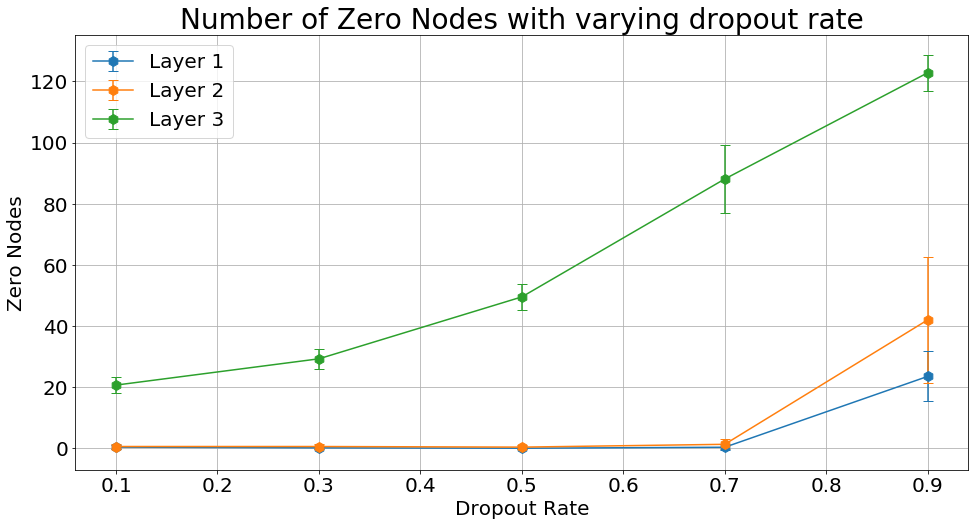

In [70]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Zero Nodes']].std().to_numpy()
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Zero Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Zero Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/zero_nodes_MLP_dropout_fmnist.png")

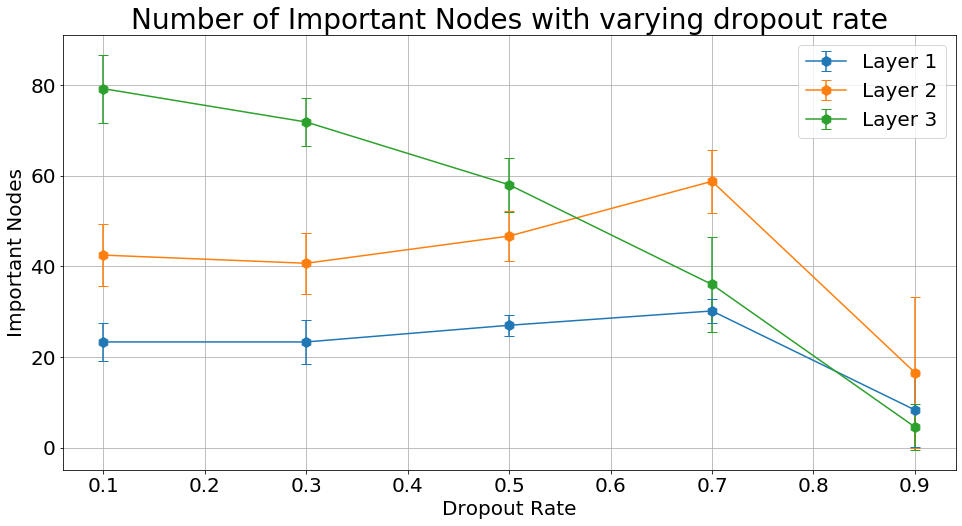

In [71]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Important Nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Important Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/imp_nodes_MLP_dropout_fmnist.png")

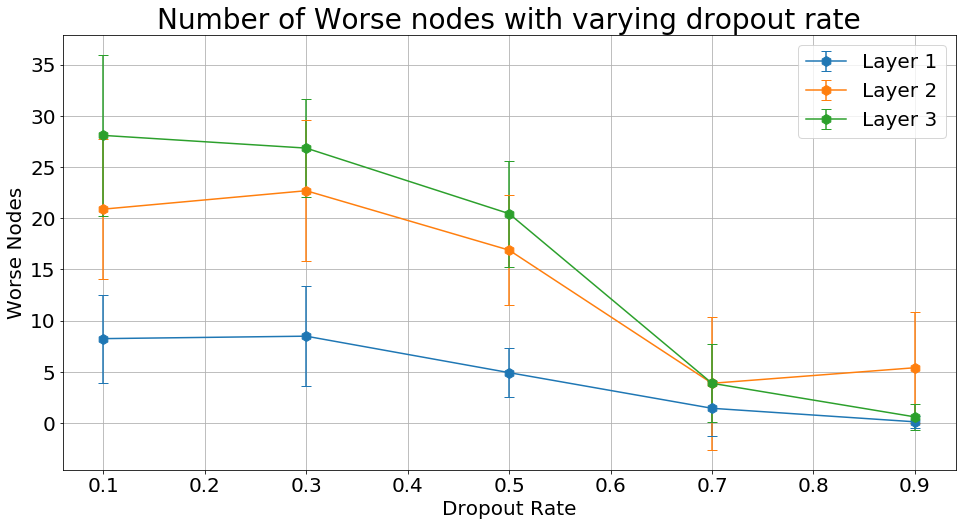

In [72]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = NI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = NI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = NI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Number of Worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Worse Nodes", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/worse_nodes_MLP_dropout_fmnist.png")

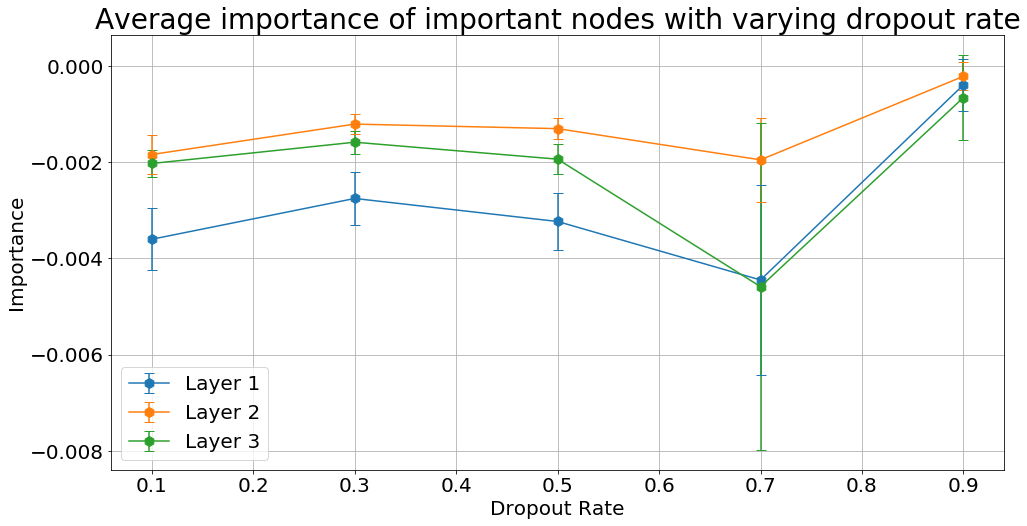

In [73]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Important Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average importance of important nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/avg_imp_nodes_MLP_dropout_fmnist.png")

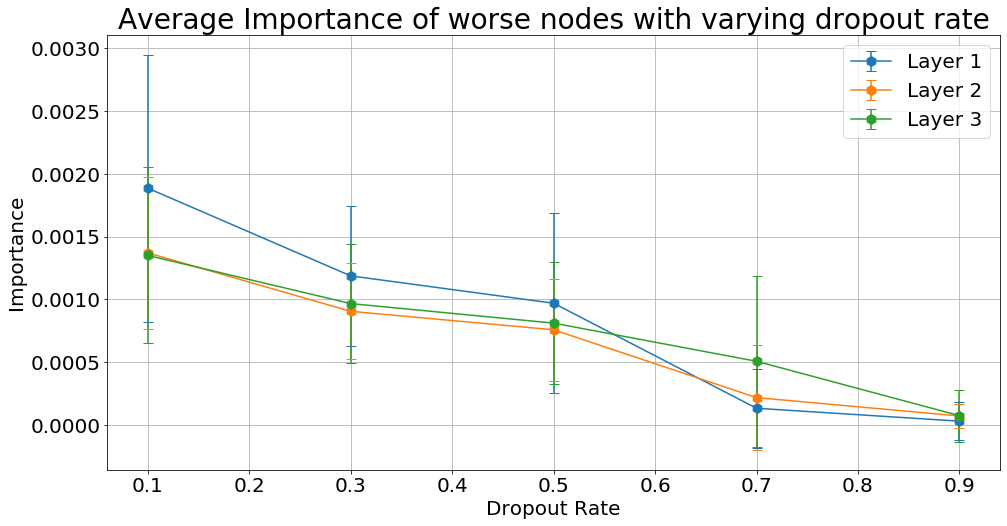

In [74]:
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_1 = AvgNI_1.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_2 = AvgNI_2.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
m_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].mean().to_numpy()
std_3 = AvgNI_3.loc[idx[:], idx[:,'Worse Nodes']].std().to_numpy()
plt.rcParams["figure.figsize"] = (16,8)
plt.errorbar(x=dropout_rate, y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 1')
plt.errorbar(x=dropout_rate, y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 2')
plt.errorbar(x=dropout_rate, y=m_3, yerr=std_3, capsize=5, marker='h', markersize=10, alpha=1, label='Layer 3')
plt.legend(fontsize=20)
plt.title("Average Importance of worse nodes with varying dropout rate", size=28)
plt.xlabel("Dropout Rate", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Importance", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/avg_worse_nodes_MLP_dropout_fmnist.png")